# EEG Problem Set: Analysis
This problem set requires you to have already run the `eeg-preprocessing.ipynb` notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne import set_log_level
set_log_level(verbose=False)
%matplotlib inline

This assignment will consist of 3 parts:
- Part 1: ERP analysis
- Part 2: Time-frequency analysis
- Part 3: Experimental design question

## Part 1
### Instructions

In this problem set, you will be performing an ERP analysis and time-frequency analysis on a preprocessed dataset. First let's describe the task in greater detail. 

This experiment is based on the oddball paradigm used in [Luck et al., (2009)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-8986.2009.00817.x). In the oddball paradigm, a letter or digit was presented every 1100-1500 ms. Subjects were instructed to press a button with one hand for digits and with the other hand for letters. For a given trial block, either the letters or the digits were rare (20%) and the other category was frequent (80%). The stimulus category (digits or letters), the probability (80% or 20%) and the hand used for response (left or right) were counterbalanced, leading to 8 experimental conditions. The probability manipulation was designed to isolate the probability-sensitive P300 component. Different event codes were used for the digits when they were rare (`20_Dig_L` for response with left hand, `20_Dig_R` for response with right), the digits when they were frequent (`80_Dig_L`, `80_Dig_R`), the letters when they were rare (`20_Let_L`, `20_Let_R`), and the letters when they were frequent (`80_Let_L`, `80_Let_R`). These event codes are summarized below:

|Left/Right|Rare|Frequent|
|---|---|---|
|Digits|20_Dig_L/20_Dig_R|80_Dig_L/80_Dig_R|
|Letters|20_Let_L/20_Let_R|80_Let_L/80_Let_R|

The P300 is a neural marker of surprise. As such, we expect a larger P300 during the rare trials than for the frequent trials. In this notebook, you will analyze the difference (if any) in P300s between conditions. Specifically, you will (1a) perform permutation testing, and (1b) visualize the evoked potentials. After this, you will (2) do a time-frequency analysis to identify a signature of conflict in the theta (4-8 Hz) band.

We've included the script used for preprocessing (`eeg-preprocessing.ipynb`) and an inspector (`eeg-visualization.ipynb`) if you'd like to take a closer look at the data.

Here is a visualization of the events in the experiment, using the raw data:

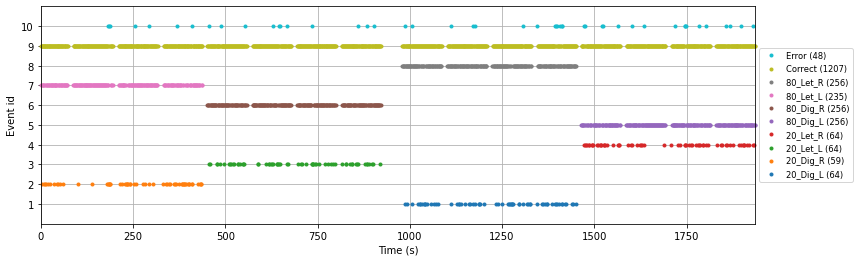

In [2]:
from mne.viz import plot_events
from mne.io import read_raw_fif
from mne import events_from_annotations

# Gather events
raw = read_raw_fif('sub-01_task-digitsymbol_raw.fif')
events, event_id = events_from_annotations(read_raw_fif(
    'sub-01_task-digitsymbol_raw.fif', preload=False, verbose=False))

# Plot the events
fig, ax = plt.subplots(1,1,figsize=(16,4))
fig = plot_events(events, raw.info['sfreq'], raw.first_samp, event_id=event_id, axes=ax);

We begin by loading in the epoched data.

In [3]:
from mne import read_epochs

# Load epochs
epochs = read_epochs('sub-01_task-digitsymbol-epo.fif', preload=True, verbose=False)
print(epochs)

<EpochsFIF |  2308 events (all good), -0.2 - 1 sec, baseline -0.2 – 0 sec, ~160.9 MB, data loaded,
 '20_Dig_R': 61
 '80_Let_L': 61
 '80_Dig_R': 249
 '20_Let_L': 252
 '80_Let_R': 224
 '20_Dig_L': 247
 '80_Dig_L': 1167
 '20_Let_R': 47>


### Step 1a: event related potential (ERP) analysis

In the following, you will look to find the P300 in the evoked potentials of each condition.

#### Evoked potentials

First, make two evoked potentials:
- *frequent*: an average of all the frequent (80) trials, collapsing over symbol and hand.
- *rare*: an average of all the rare (20) trials, collapsing over symbol and hand.

In [4]:
frequent_evoked = epochs['80_Dig_L', '80_Dig_R', '80_Let_L', '80_Let_R'].average()
rare_evoked = epochs['20_Dig_L', '20_Dig_R', '20_Let_L', '20_Let_R'].average()

#### Compare evoked potentials
Using `mne.viz.plot_evoked_topo`, plot a comparison of all the evoked potentials across the scalp.

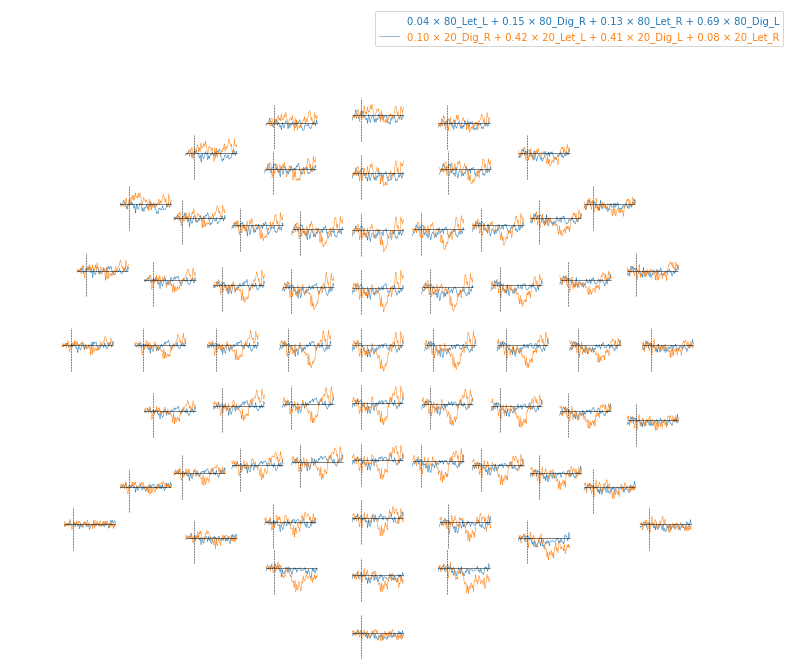

In [5]:
from mne.viz import plot_evoked_topo

fig, ax = plt.subplots(1,1,figsize=(14,12))
plot_evoked_topo([frequent_evoked, rare_evoked], axes=ax);

**Q**: Is there an obvious P300?

> Yes, there is a P300 where there is a positive deviation in the rare events (orange) from the frequent (blue) events.

**Q**: If there is a P300, is it prominent everywhere?

> No, it is most prominent in the prefrontal region.

#### Topographic plots
Make topographic plots for the **difference wave**  Remember that the P300 should start around 300 ms and persist for many hundreds of milliseconds.

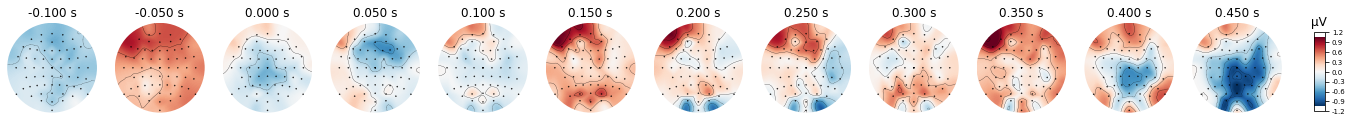

In [6]:
from mne import combine_evoked

# Compute difference wave
DW = combine_evoked([frequent_evoked, rare_evoked], [-1,1])

# topographic plots
DW.plot_topomap(times=np.arange(-0.1,0.5,0.05));

**Q**: If present, when is the P300 most prominent?

> It is most prominent at 350 ms.

**Q**: If present, where is the P300 most prominent?

> It is most prominent over the left prefrontal/frontal electrodes.

### Step 1b: replication and permutation testing

In this final step, we will formalize our analysis by replicating and extending Figure 2 from [Luck et al., (2009)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-8986.2009.00817.x). To do so, we will perform permutation testing, testing for differences in the amplitude of the P300 between conditions across three sets of channels.

First, make two separate epoch objects:
- *frequent*: all the frequent (80)
- *rare*: all the rare (20) trials

In [7]:
frequent = epochs['80_Dig_L', '80_Dig_R', '80_Let_L', '80_Let_R']
rare = epochs['20_Dig_L', '20_Dig_R', '20_Let_L', '20_Let_R']

Next, find the corresponding indices for the following sets of channels. Find the indices using `mne.pick_channels`. 
- frontal: F1, Fz, F2
- central: C3, Cz, C4
- parietal: P3, Pz, P4

In [8]:
from mne import pick_channels

frontal_ind = pick_channels(frequent.info['ch_names'], ['F1', 'Fz', 'F2'])
central_ind = pick_channels(frequent.info['ch_names'], ['C3', 'Cz', 'C4'])
parietal_ind = pick_channels(frequent.info['ch_names'], ['P3', 'Pz', 'P4'])

Following the permutation testing code presented in the `eeg-02` demo, write a *for loop* that performs the following for each channel set:

1. Extracts the trials by channel set and condition (frequent, rare).
2. Average over the channels.
3. Performs permutation testing with 1024 permutations.
4. Plots the evoked potential (i.e. average over trials) per condition and highlights significant clusters.

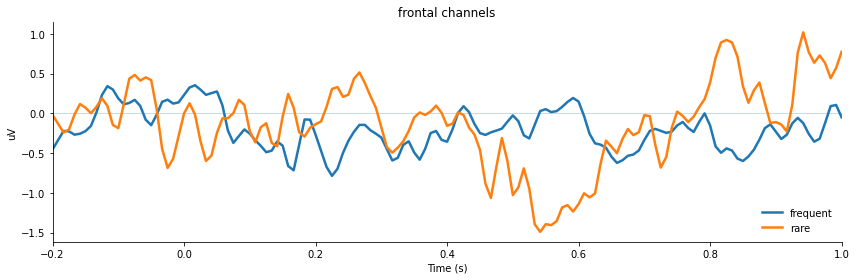

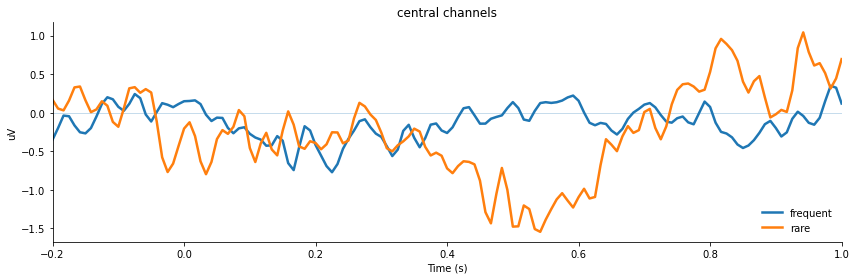

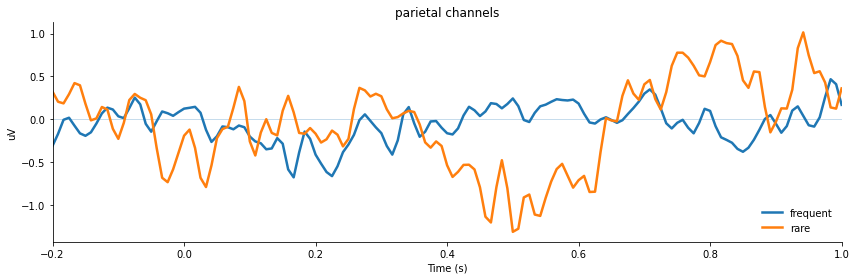

In [9]:
from mne.stats import permutation_cluster_test

frontal = ['F1', 'Fz', 'F2']
central = ['C3', 'Cz', 'C4']
parietal = ['P3', 'Pz', 'P4']
channel_sets = ['frontal', 'central', 'parietal']

for set in channel_sets:

    # Extract data for each channel set and condition
    data_freq = frequent.copy().pick_channels(eval(set)).get_data().squeeze()
    data_rare = rare.copy().pick_channels(eval(set)).get_data().squeeze()
    
    # average across channel
    data_freq_mean = np.mean(data_freq, axis = 1)
    data_rare_mean = np.mean(data_rare, axis = 1)
    
    data = [data_freq_mean, data_rare_mean]

    # evoked potentials    
    evokeds = [np.mean(data[0], axis=0) * 1e6, np.mean(data[1], axis=0) * 1e6]

    # Using F-statistic as default
    F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(data, n_permutations=1024, 
                                                               seed=47404, tail=1)

    # Plotting
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    ax.plot(epochs.times, evokeds[0], lw=2.5, label='frequent') 
    ax.plot(epochs.times, evokeds[1], lw=2.5, label='rare')
    ymin, ymax = ax.get_ylim()

    # Plot clusters
    for cluster, pval in zip(clusters, cluster_pv): 
        if pval < 0.05:
            center = epochs.times[cluster].mean()
            ax.fill_between(epochs.times[cluster], ymin, ymax, color='0.8', alpha=0.5)
            ax.annotate('p = %0.3f' %pval, (0,0), (center, ymax), ha='center', va='top', fontsize=14)

    # Add details
    ax.hlines(0, epochs.tmin, epochs.tmax, linewidth=0.5, alpha=0.5, zorder=0)
    ax.set(xlim=(epochs.tmin, epochs.tmax), xlabel='Time (s)', ylim=(ymin, ymax), 
           ylabel='uV', title= set + ' channels')
    ax.legend(loc=4, frameon=False)

    sns.despine()
    plt.tight_layout()

## Part 2

In the previous section, you measured the P300 in response to rare trials. During rare trials, participants need to inhibit a prepotent motor response (i.e. responding as if they saw a frequent trial). The need for motor inhibition is often said to generate a conflict signal. In scalp EEG, conflict signals are detectable as increases in non-phase-locked theta (4-8 Hz) power. In this final section, you will follow the steps as detailed in [Cohen & Donner (2013)](https://www.physiology.org/doi/full/10.1152/jn.00479.2013) to measure the theta signature of conflict in rare trials.

### Step 2a: spectral decomposition

With the epochs loaded, you will perform a spectral decomposition on the data to measure the time-frequency content of the data. Following [Cohen & Donner (2013)](https://www.physiology.org/doi/full/10.1152/jn.00479.2013), you will use Morlet wavelet decomposition. 

First you need to define the frequencies you want to measure. Using `np.logspace`, generate a vector of 12 logarithmically-spaced frequencies beginning at 4 Hz and ending at 30 Hz. (Note: If you do this correctly, your vector should start and end with 4 and 30, respectively.)

In [10]:
freqs = np.logspace(np.log(4), np.log(30), num=12, base=np.e) 

In this next section, you are going to perform the spectral decomposition. The challenge is that you will need to measure non-phase-locked power. In other words, you are decomposing the epochs after the evoked potential has been subtracted. Importantly, this subtraction must occur within each condition. 

To assist you, we have started a for loop. In each cycle of the for loop, you will perform the following steps:

1. Make copy of the per-condition epochs.
2. Subtract evoked potential from copy.
3. Perform Morlet wavelet decomposition on the evoked-subtracted copy using the following parameters:
    - `freqs`: as defined above
    - `n_cycles`: 3
    - `return_itc`: False
4. Apply a baseline transformation to the power estimates making sure to:
    - Baseline correct (-0.1, 0.0)
    - Convert power into decibels.

In [11]:
from mne.time_frequency import tfr_morlet

# Define conditions
conditions = ['20_Dig_L', '20_Dig_R', '20_Let_L', '20_Let_R',
              '80_Dig_L', '80_Dig_R', '80_Let_L', '80_Let_R']

n_cycles = 3

# Main loop
spectral = []
for k in conditions:

    ## Make temporary copy.
    trials = epochs[k].copy()
    
    ## Subtract evoked.
    subtracted_evoked = trials.subtract_evoked()
    
    ## Perform Morlet-based time-frequency decomposition.
    cond_power = tfr_morlet(subtracted_evoked, freqs, n_cycles, average=True,
                      return_itc=False, verbose=False)
    
    ## Apply baseline transformation.
    baseline = (-0.1, 0.0)
    cond_power = cond_power.apply_baseline(baseline, 'logratio')
    cond_power_dec = 10 * cond_power.data
    
    ## Store.
    spectral.append(cond_power_dec)
    
# Convert to NumPy array
spectral = np.array(spectral)

### Step 2b: compute averages 

Using the power estimates defined above, create an average spectrogram for the frequent and rare trials.

In [12]:
freq_ind = np.arange(0,4)
rare_ind = np.arange(4,8)

freq_avg_spec = np.mean(spectral[freq_ind], axis = 0)
rare_avg_spec = np.mean(spectral[rare_ind], axis = 0)

### Step 2c: visualize spectrograms

#### Frequent trials

Plot the spectrogram of the frequent trials for channel FCz using your favorite heatmap function.

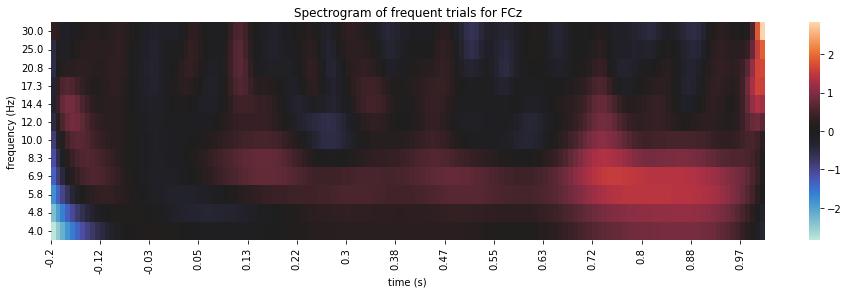

In [13]:
freq_spec_fcz = freq_avg_spec[epochs.ch_names.index('FCz')]

# plot
fig, ax = plt.subplots(1,1,figsize=(16,4))
sns.heatmap(freq_spec_fcz, center=0, yticklabels=freqs.round(1), ax=ax)
ax.set(xticks=np.arange(epochs.times.size)[::10], xticklabels=epochs.times[::10].round(2),
       xlabel='time (s)', ylabel='frequency (Hz)', title='Spectrogram of frequent trials for FCz')
ax.invert_yaxis()

#### Rare trials

Plot the spectrogram of the rare trials for channel FCz using your favorite heatmap function.

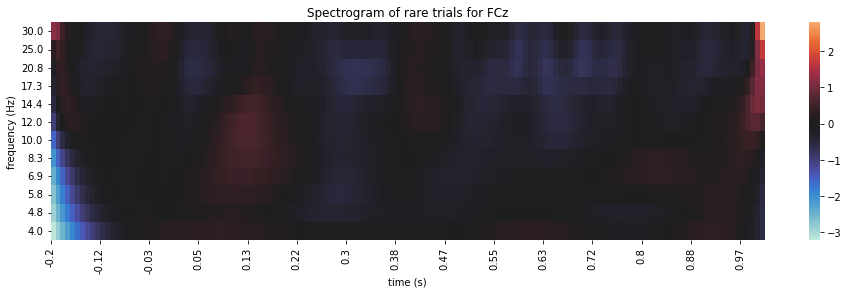

In [14]:
rare_spec_fcz = rare_avg_spec[epochs.ch_names.index('FCz')]

# plot
fig, ax = plt.subplots(1,1,figsize=(16,4))
sns.heatmap(rare_spec_fcz, center=0, yticklabels=freqs.round(1), ax=ax)
ax.set(xticks=np.arange(epochs.times.size)[::10], xticklabels=epochs.times[::10].round(2),
       xlabel='time (s)', ylabel='frequency (Hz)', title='Spectrogram of rare trials for FCz')
ax.invert_yaxis()

#### Rare - frequent trials

Plot the spectrogram of the rare - frequent trials for channel FCz using your favorite heatmap function.

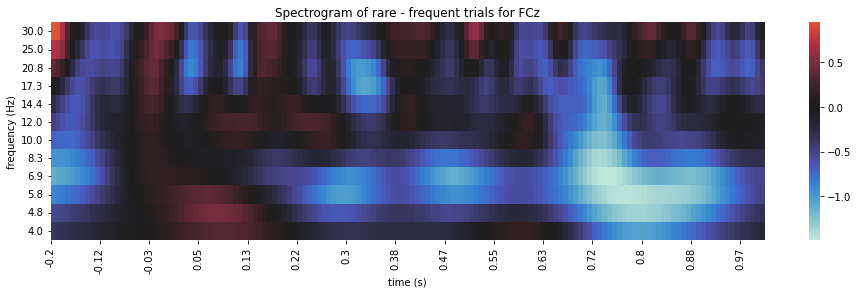

In [15]:
diff = rare_spec_fcz - freq_spec_fcz

# plot
fig, ax = plt.subplots(1,1,figsize=(16,4))
sns.heatmap(diff, center=0, yticklabels=freqs.round(1), ax=ax)
ax.set(xticks=np.arange(epochs.times.size)[::10], xticklabels=epochs.times[::10].round(2),
       xlabel='time (s)', ylabel='frequency (Hz)', title='Spectrogram of rare - frequent trials for FCz')
ax.invert_yaxis()

**Q:** Is there an increase in theta power between frequent and rare trials? If so, where?

> The spectrogram shows a decrease in theta power in the 4-8 Hz range for rare trials, as compared to frequent trials. This decrease starts around 300 ms and is strongest around 700-900ms.

**Q:** Does the plot above resemble the non-phase-locked power from the midfrontal electrode (FCz) in Figure 2 of [Cohen & Donner (2013)](https://www.physiology.org/doi/full/10.1152/jn.00479.2013)?

> No my plot does not resemble the non-phase-locked power in Figure 2. My plot does not show a clean increase in theta power and decrease in higher frequencies starting around 300m as does Figure 2.


## Part 3

The final question on this problem set is about experimental design.

You've just received a manuscript for review from an eminent  neuroeconomics researcher who claims to have discovered an ERP that registers when someone learns about a potentially lucrative financial opportunity. You turn a critical eye towards the paper, and see that the results have probably been over-interpreted. 

Here is the design: A computer presented numbers on a screen representing the quantity that may be won or lost on a given trial. If the amount was positive, the numbers were green. If the amount was negative, the numbers were red. The subject was asked to press a button if they wanted to “place a bet”. The cost of a bet was \\$0.01. If the subject chose to place a bet, two seconds after their response they were informed as to whether they won. 80% of the time they won the promised amount, but 20% of the time they won or lost a random amount between -\\$10 and \\$10. The average payout on positive trials was \\$6, and the average loss on negative trials was \\$5. A payout or loss only occurred if the subject placed a bet. To simulate the negative bias of the financial media, only 10% of trials were positive, while 90% were negative. 

The results: Behaviorally, subjects bet on 95% of positive trials and only 1% of negative trials. There is an ERP for the green positive numbers that peaks at about 210 ms over parietal cortex. The stimulus-locked ERP pattern evoked by the colored number looks like this: 

![](images/part3-figure.png)

(Note that negative voltages are plotted here as positive on the Y axis as per traditional practice—and that's not a mistake or a confound.) 


**Q:** Name at least two possible confounds with this experiment. (One extra-credit point can be earned by naming three confounds.)

> 1) The initial presentation of the numbers involves two changing variables: dollar amount and color. The number itself corresponds to how much money is at stake, and the color corresponds to whether this money can be gained or loss. Since numeric value is varied in addition to color, you can't isolate gain/loss of money as the cause of the ERP differences between colors - perhaps the magnitude of the money to be won or lost is also influencing the person's reaction.

> 2) Since only 10% of trials were positive whereas 90% were negative, there are many more trials averaged over in the negative condition to make the red ERP. Perhaps if there were more positive trials, the green ERP peak at 210ms would not be as large. 